In [12]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from matplotlib import pyplot as plt

In [13]:
%matplotlib inline

In [3]:
tf.__version__

'1.14.0'

In [4]:
with open('x_raw.pickle', 'rb') as handle:
    x_raw = pickle.load(handle)
with open('label.pickle', 'rb') as handle:
    label = pickle.load(handle)

In [5]:
len(x_raw)

339

In [6]:
len(label)

339

### input size vs. accuracy

In [291]:
sample_size_list = [m.shape[0] for m in x_raw]
print(np.max(sample_size_list), min(sample_size_list), np.median(sample_size_list))

973 94 171.0


In [292]:
pd.Series(sample_size_list).describe()

count    339.000000
mean     176.672566
std       60.067631
min       94.000000
25%      155.000000
50%      171.000000
75%      186.000000
max      973.000000
dtype: float64

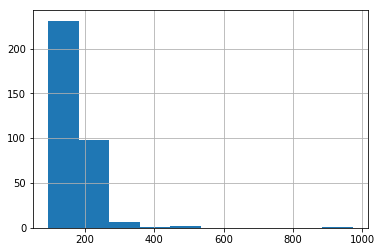

In [293]:
pd.Series(sample_size_list).hist()
plt.show()

In [17]:
input_size_list = [50, 90, 120, 150, 180, 200]

#### Downsampling (random) + zero padding (end)

In [467]:
def preprocess(input_size, raw_data, downsample='random', 
               padding='end', random_seed=11):
    """
    Preprocess each data point of raw_data with certain rules given input_size.
    If input_size < raw_data[i].shape[0], downsample with 'random' or 'equal_space';
    If input_size > raw_data[i].shape[0], pad with zeros to the 'beginning' or 'end' or 'both'
    As raw_data[i] has dim of m*3, padding [0, 0, 0] to it
    """
    sampled_data = []
    
    for elem in raw_data:
        if input_size < elem.shape[0]:
            if downsample == 'random':
                np.random.seed(random_seed)
                # randomly sampling the indices for each matrix
                random_idx = np.random.randint(0, elem.shape[0], input_size)
                # sort the indices to match the timestamps
                random_idx.sort()
            else:
                # add "equal_space"
                random_idx = range(input_size)
                pass
            sampled_data.append(np.array(elem[random_idx, :]))
        elif input_size > elem.shape[0]:
            padding_size = input_size - elem.shape[0]
            padding_matrix = np.zeros(dtype=np.float32, 
                                      shape=(padding_size, elem.shape[1]))
            #padding_matrix = np.asarray([0.0]*elem.shape[1]*padding_size, 
                                        #dtype=np.float32).reshape(-1, elem.shape[1])
            if padding == 'end':
                sampled_data.append(np.vstack([elem, padding_matrix]))
            elif padding == 'begin':
                sampled_data.append(np.vstack([padding_matrix, elem]))
            else:
                # need to implement adding to both ends
                sampled_data.append(np.vstack([elem, padding_matrix]))
                pass
        else:
            sampled_data.append(elem)
    
    return sampled_data

In [182]:
input_size = 94
x_downsampled = []
for elem in x_raw:
    np.random.seed(11)
    # randomly sampling the indices for each matrix
    random_idx = np.random.randint(0, elem.shape[0], input_size)
    # sort the indices to match the timestamps
    random_idx.sort()
    # downsampling
    x_downsampled.append(elem[random_idx, :])
x_downsampled = np.array(x_downsampled)

In [183]:
x_downsampled.shape

(339, 94, 3)

In [169]:
sample_size = x_downsampled.shape[0]

In [334]:
x_sampled = preprocess(140, x_raw)

In [336]:
np.array(x_sampled).shape

(339, 140, 3)

In [189]:
(x_sampled - x_downsampled).sum()

26.647596059000005

In [21]:
num_classes = 10

#### shuffling and splitting data

In [464]:
from sklearn.preprocessing import PolynomialFeatures
def split_data(sampled_data, label, n_classes=10, train_idx=240,
               shuffle=True, feature='linear', degree=3, 
               norm=False, random_seed=11):  
    """
    sampled_data is a list of matrices
    The function shuffles X+y
    splits from train_idx
    extend features
    return 4 matrices
    """
    sample_size = len(sampled_data)
    y = np.eye(num_classes)[np.array(label)]
    if feature == 'linear':
        X = np.asarray(sampled_data, dtype=np.float32).reshape(sample_size, -1)
    elif feature == 'poly':
        tmp_sampled_poly = []
        for elem in sampled_data:
            poly = PolynomialFeatures(degree=degree)
            tmp_sampled_poly.append(poly.fit_transform(elem))
        X = np.asarray(tmp_sampled_poly, dtype=np.float32).reshape(sample_size, -1)
    
    #print(X.shape, y.shape)
    tmp = np.hstack([X, y])
    np.random.seed(random_seed)
    np.random.shuffle(tmp)
    X = tmp[:, :-num_classes]
    y = tmp[:, -num_classes:]
    
    X_train, X_test = X[:train_idx, :], X[train_idx:, :]
    y_train, y_test = y[:train_idx, :], y[train_idx:, :]
    
    return X_train, X_test, y_train, y_test

In [220]:
X_train, X_test, y_train, y_test = split_data(x_sampled, label, random_seed=3)

(339, 360) (339, 10)


#### Input_size vs. Accuracy

In [461]:
input_size_list = range(10, 200, 10)
random_seeds = [1, 3, 11, 23, 56, 97]
num_classes = 10

In [465]:
acc_svm_random_end_unnorm = []

for input_size in input_size_list:
    for random_seed in random_seeds:
        x_sampled = preprocess(input_size, x_raw, random_seed=random_seed)
        #print("Input size: {}, random seed: {}, sampled data {}". format(input_size, random_seed, sampled_data.shape))
        X_train, X_test, y_train, y_test = split_data(x_sampled, label, 
                                                      random_seed=random_seed)
        
        svc = SVC(C=1.0, kernel='poly', degree=3, decision_function_shape='ovo', gamma='auto')
        svc.fit(X_train, np.dot(y_train, range(num_classes)))
        acc_svm_random_end_unnorm.append(svc.score(X_test, np.dot(y_test, range(num_classes))))

In [468]:
acc_svm_random_begin_unnorm = []

for input_size in input_size_list:
    for random_seed in random_seeds:
        x_sampled = preprocess(input_size, x_raw, padding='begin',
                               random_seed=random_seed)
        #print("Input size: {}, random seed: {}, sampled data {}". format(input_size, random_seed, sampled_data.shape))
        X_train, X_test, y_train, y_test = split_data(x_sampled, label, 
                                                      random_seed=random_seed)
        
        svc = SVC(C=1.0, kernel='poly', degree=3, decision_function_shape='ovo', gamma='auto')
        svc.fit(X_train, np.dot(y_train, range(num_classes)))
        acc_svm_random_begin_unnorm.append(svc.score(X_test, np.dot(y_test, range(num_classes))))

In [469]:
def mean_std_acc(acc_list, num_seeds=6):
    acc_matrix = np.array(acc_list).reshape(-1, num_seeds)
    acc_mean = acc_matrix.mean(axis=1)
    acc_std = acc_matrix.std(axis=1)
    return acc_mean, acc_std

In [473]:
acc_mean_1, acc_std_1 = mean_std_acc(acc_svm_random_end_unnorm)
acc_mean_2, acc_std_2 = mean_std_acc(acc_svm_random_begin_unnorm)

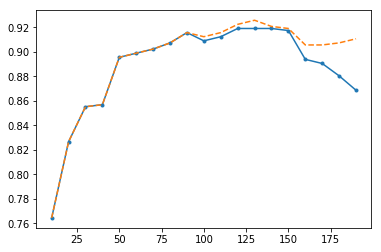

In [475]:
plt.plot(input_size_list, acc_mean_1, '.-')
plt.plot(input_size_list, acc_mean_2, '--')
plt.show()

#### Logistic regression

In [477]:
acc_lg_random_end_unnorm = []

for input_size in input_size_list:
    for random_seed in random_seeds:
        x_sampled = preprocess(input_size, x_raw, random_seed=random_seed)
        #print("Input size: {}, random seed: {}, sampled data {}". format(input_size, random_seed, sampled_data.shape))
        X_train, X_test, y_train, y_test = split_data(x_sampled, label, 
                                                      random_seed=random_seed)
        
        lg = LogisticRegression(penalty='l2', C=1.0, solver='newton-cg', multi_class='multinomial')
        lg.fit(X_train, np.dot(y_train, range(num_classes)))
        acc_lg_random_end_unnorm.append(lg.score(X_test, np.dot(y_test, range(num_classes))))

In [483]:
acc_lg_random_begin_unnorm = []

for input_size in input_size_list:
    for random_seed in random_seeds:
        x_sampled = preprocess(input_size, x_raw, padding='begin',
                               random_seed=random_seed)
        #print("Input size: {}, random seed: {}, sampled data {}". format(input_size, random_seed, sampled_data.shape))
        X_train, X_test, y_train, y_test = split_data(x_sampled, label, 
                                                      random_seed=random_seed)
        
        lg = LogisticRegression(penalty='l2', C=1.0, solver='newton-cg', multi_class='multinomial')
        lg.fit(X_train, np.dot(y_train, range(num_classes)))
        acc_lg_random_begin_unnorm.append(lg.score(X_test, np.dot(y_test, range(num_classes))))

In [484]:
acc_mean_lg1, acc_std_lg1 = mean_std_acc(acc_lg_random_end_unnorm)
acc_mean_lg2, acc_std_lg2 = mean_std_acc(acc_lg_random_begin_unnorm)

In [485]:
acc_mean_lg1

array([0.68181818, 0.78619529, 0.81313131, 0.84006734, 0.84680135,
       0.86531987, 0.86531987, 0.87542088, 0.88047138, 0.87710438,
       0.89057239, 0.88047138, 0.89057239, 0.87542088, 0.87205387,
       0.85353535, 0.82491582, 0.80639731, 0.78282828])

In [486]:
acc_mean_lg2

array([0.68181818, 0.78619529, 0.81313131, 0.84006734, 0.84680135,
       0.86531987, 0.86531987, 0.87542088, 0.88047138, 0.87710438,
       0.8956229 , 0.89225589, 0.9023569 , 0.88552189, 0.8956229 ,
       0.87878788, 0.88552189, 0.87878788, 0.88215488])

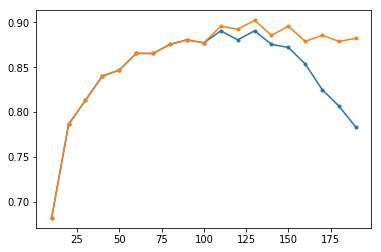

In [487]:
plt.plot(input_size_list, acc_mean_lg1, '.-')
plt.plot(input_size_list, acc_mean_lg2, '.-')
plt.show()

#### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
rf.score(X_train, y_train)

0.8166666666666667

In [33]:
rf.score(X_test, y_test)

0.2828282828282828

#### Logistic Regression

In [270]:
from sklearn.linear_model import LogisticRegression

In [271]:
lg = LogisticRegression(penalty='l2', C=1.0, solver='newton-cg', multi_class='multinomial')
lg.fit(X_train, np.dot(y_train, range(num_classes)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [272]:
lg.score(X_train, np.dot(y_train, range(num_classes)))

1.0

In [273]:
lg.score(X_test, np.dot(y_test, range(num_classes)))

0.8282828282828283

In [274]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [258]:
cm = confusion_matrix(np.dot(y_test, range(num_classes)), 
                      lg.predict(X_test))

In [259]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [260]:
cm

array([[12,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  1,  9,  0,  0,  2,  0],
       [ 0,  1,  0,  0,  0,  0, 13,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0,  0,  6]])

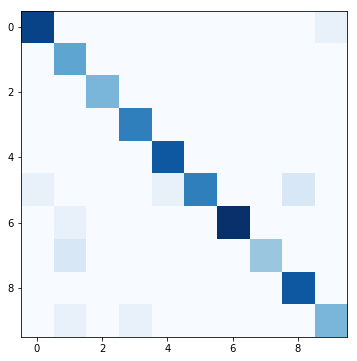

In [261]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.show()

#### SVM

In [281]:
from sklearn.svm import SVC

In [287]:
svc = SVC(C=1.0, kernel='poly', degree=3, decision_function_shape='ovo')
svc.fit(X_train, np.dot(y_train, range(num_classes)))

/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [288]:
svc.score(X_train, np.dot(y_train, range(num_classes)))

1.0

In [289]:
svc.score(X_test, np.dot(y_test, range(num_classes)))

0.7777777777777778

In [266]:
cm = confusion_matrix(np.dot(y_test, range(num_classes)), 
                      svc.predict(X_test))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

array([[12,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  3,  0],
       [ 1,  0,  0,  0,  0,  0, 13,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  1,  0,  4]])

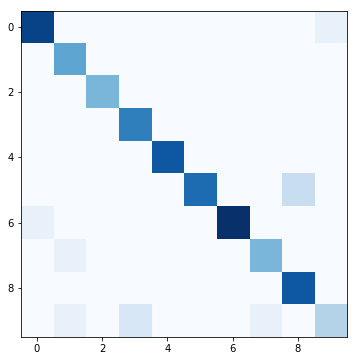

In [267]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.show()

#### DNN

In [400]:
x_sampled = preprocess(120, x_raw)
len(x_sampled)

339

In [401]:
np.asarray(x_sampled).shape

(339, 120, 3)

In [425]:
X_train, X_test, y_train, y_test = split_data(x_sampled, label, feature='linear',
                                              random_seed=11)

(339, 360) (339, 10)


In [407]:
lg = LogisticRegression(penalty='l2', C=1.0, solver='newton-cg', multi_class='multinomial')
lg.fit(X_train, np.dot(y_train, range(num_classes)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [408]:
lg.score(X_train, np.dot(y_train, range(num_classes)))

1.0

In [409]:
lg.score(X_test, np.dot(y_test, range(num_classes)))

0.8383838383838383

In [426]:
tf.reset_default_graph()

In [427]:
input_shape =  X_train.shape[1]
fc1_shape = 32
fc2_shape = 64

In [428]:
x = tf.placeholder(tf.float32, shape=[None, input_shape], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_')
keep_proba = tf.placeholder(tf.float32, shape=())

In [429]:
with tf.variable_scope("fc1") as scope:
    weights = tf.get_variable(name="weights", shape=[input_shape, fc1_shape], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    bias = tf.get_variable(name="bias", shape=[fc1_shape], dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    fc = tf.matmul(x, weights, name="matmul")
    pre_activation = tf.add(fc, bias)
    fc1 = tf.nn.relu(pre_activation, name="relu")
    dp1 = tf.nn.dropout(fc1, keep_prob=keep_proba)

print(weights)
print(dp1)

<tf.Variable 'fc1/weights:0' shape=(360, 32) dtype=float32_ref>
Tensor("fc1/dropout/mul_1:0", shape=(?, 32), dtype=float32)


In [430]:
with tf.variable_scope("fc2") as scope:
    weights = tf.get_variable(name="weights", shape=[fc1_shape, fc2_shape], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    bias = tf.get_variable(name="bias", shape=[fc2_shape], dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    fc = tf.matmul(dp1, weights, name="matmul")
    pre_activation = tf.add(fc, bias)
    fc2 = tf.nn.relu(pre_activation, name="relu")
    dp2 = tf.nn.dropout(fc2, keep_prob=keep_proba)

print(weights)
print(fc2)

<tf.Variable 'fc2/weights:0' shape=(32, 64) dtype=float32_ref>
Tensor("fc2/relu:0", shape=(?, 64), dtype=float32)


In [431]:
with tf.variable_scope("fc3") as scope:
    weights = tf.get_variable(name="weights", shape=[fc2_shape, num_classes], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    bias = tf.get_variable(name="bias", shape=[num_classes], dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    fc = tf.matmul(dp2, weights, name="matmul")
    logits = tf.add(fc, bias, name="logits")
    y_proba = tf.nn.softmax(logits, name="y_proba")
    y_pred = tf.argmax(logits, axis=1, name="y_pred")

print(weights)
print(logits)

<tf.Variable 'fc3/weights:0' shape=(64, 10) dtype=float32_ref>
Tensor("fc3/logits:0", shape=(?, 10), dtype=float32)


In [432]:
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits, name="cross_entropy")
    loss = tf.reduce_mean(cross_entropy, name="cross_entropy_loss")
    #train_step = tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(loss, name="train_step")
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss, name="train_step")
    #lr = tf.placeholder(tf.float32, shape=[])
    #train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss, name="train_step")
print(cross_entropy)
print(loss)

Tensor("loss/cross_entropy/Reshape_2:0", shape=(?,), dtype=float32)
Tensor("loss/cross_entropy_loss:0", shape=(), dtype=float32)


In [433]:
with tf.name_scope("eval"):
    correct = tf.equal(y_pred, tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
print(correct)
print(accuracy)

Tensor("eval/Equal:0", shape=(?,), dtype=bool)
Tensor("eval/accuracy:0", shape=(), dtype=float32)


#### training

In [446]:
sess = tf.Session()
# Initialize the variables (i.e. assign their default value)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [447]:
train_loss, train_accuracy = sess.run([loss, accuracy], 
                                      feed_dict={x: X_train, 
                                                 y_: y_train,
                                                 keep_proba: 1.0})
print('Epoch %d, training loss: %g, training accuracy: %g' % (0, train_loss, train_accuracy))
val_loss, val_accuracy = sess.run([loss, accuracy], 
                                  feed_dict={x: X_test,
                                             y_: y_test,
                                             keep_proba: 1.0})
print('Epoch %d, validation loss: %g, validation accuracy %g' % (0, val_loss, val_accuracy))
#results["init_loss"].append(val_loss)
#results["init_acc"].append(val_accuracy)
max_accuracy = val_accuracy

Epoch 0, training loss: 7.65582, training accuracy: 0.1125
Epoch 0, validation loss: 8.36679, validation accuracy 0.0808081


In [448]:
batch_size = 10
n_epochs = 50
n_batches = int(X_train.shape[0] / batch_size)
display_step = 5
max_accuracy = 0
learning_rate = 0.001
decay_rate = 0.999

save_ckps_dir = "./chkps_mnist_air/dnn2"

In [456]:
for i in range(n_epochs):
    batch_start = 0
    batch_end = batch_size
    for j in range(n_batches):
        batch_images, batch_labels = X_train[batch_start:batch_end, :], y_train[batch_start:batch_end, :]
        sess.run(train_step, feed_dict={x: batch_images, 
                                        y_: batch_labels,
                                        keep_proba: 0.8})
        batch_start += batch_size
        batch_end += batch_size
        
    learning_rate *= decay_rate
    train_loss, train_accuracy = sess.run([loss, accuracy], 
                                          feed_dict={x: X_train, 
                                                     y_: y_train,
                                                     keep_proba: 1.0})
    #results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_accuracy)

    val_loss, val_accuracy = sess.run([loss, accuracy], 
                                      feed_dict={x: X_test,
                                                 y_: y_test, 
                                                 keep_proba: 1.0})
    #results["val_loss"].append(val_loss)
    #results["val_acc"].append(val_accuracy)
    
    if val_accuracy > max_accuracy:
        print("Save the current model!")
        max_accuracy = val_accuracy
        
        saver.save(sess, save_ckps_dir)
    
    if (i+1) % display_step == 0:
        print('Epoch %d, training loss: %g, training accuracy: %g' % (i, train_loss, train_accuracy))
        print('Epoch %d, validation loss: %g, validation accuracy %g' % (i, val_loss, val_accuracy))
        print('learning rate: {}'.format(learning_rate))

Epoch 4, training loss: 0.011407, training accuracy: 1
Epoch 4, validation loss: 0.735201, validation accuracy 0.868687
learning rate: 0.000701048912947695
Epoch 9, training loss: 0.0088539, training accuracy: 1
Epoch 9, validation loss: 0.727666, validation accuracy 0.868687
learning rate: 0.0006975506718651013
Epoch 14, training loss: 0.00989196, training accuracy: 1
Epoch 14, validation loss: 0.742058, validation accuracy 0.878788
learning rate: 0.0006940698870404747
Epoch 19, training loss: 0.00993532, training accuracy: 1
Epoch 19, validation loss: 0.730778, validation accuracy 0.878788
learning rate: 0.0006906064713669135
Epoch 24, training loss: 0.00885638, training accuracy: 1
Epoch 24, validation loss: 0.707812, validation accuracy 0.878788
learning rate: 0.0006871603381721801
Epoch 29, training loss: 0.0105332, training accuracy: 1
Epoch 29, validation loss: 0.730061, validation accuracy 0.848485
learning rate: 0.0006837314012165325
Epoch 34, training loss: 0.0102804, trainin

In [77]:
from tensorflow.saved_model import signature_def_utils, signature_constants, tag_constants
from tensorflow.saved_model import utils as save_model_utils

In [78]:
savemodel_file_path = "./savedmodel/mnist_air_dnn"

In [79]:
x_op = sess.graph.get_operation_by_name('x')
x_node = x_op.outputs[0]
pred_op = sess.graph.get_operation_by_name('fc3/y_proba')
pred = pred_op.outputs[0]

In [80]:
prediction_signature = signature_def_utils.build_signature_def(
    inputs={"input": save_model_utils.build_tensor_info(x)},
    outputs={"output":save_model_utils.build_tensor_info(pred)},
    method_name=signature_constants.PREDICT_METHOD_NAME)

W1118 16:36:16.490936 4395943360 deprecation.py:323] From <ipython-input-80-9cbaaab7d65e>:2: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [81]:
builder = tf.saved_model.builder.SavedModelBuilder(savemodel_file_path)
builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING], 
                                     signature_def_map={"predict": prediction_signature})
builder.save()

b'./savedmodel/mnist_air_dnn/saved_model.pb'

In [81]:
sess.close()